In [28]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
from torchvision import transforms

import random
import matplotlib.pyplot as plt

PATCH POSITIONAL EMBEDDINGS

 - tell the model where each patch belongs in the 2D grid
 - Transformer knows both "what" and "where"
 - fixed patterns are simple but not optimal for every task, can model non-smooth, irregular structures
 - learnable embeddings allow the model to adapt the positional information to best fit the data and task
 - model can discover more task-specific patterns of proximity and order


CLASSIFICATION TOKENS [CLS]
 - special learnable token that we prepend to the input sequence image patches before feeding it into the Transformer
 - updated through attention layers, just like other tokens
 - final [CLS] output is supposed to capture information about the entire input
 - [CLS]] vector is used to gather whatever is necessary to make a decision
 - for hard tasks, CLS can learn to pay more attention to important patches/tokens, rather than treating everything equally

In [29]:

class PatchEmbedding(nn.Module):

    def __init__(self, image_size, patch_size, dim):                            # image_size = 32, patch_size = 4
	
        super().__init__()
        self.patch_size = patch_size
        num_patches = (image_size // patch_size) ** 2                           # num_patches = 8*8 = 64
        patch_dim   = 3 * patch_size ** 2                                       # patch_dim   = 3 * 4 * 4 = 48 (no of pixels in a single RGB patch)

        self.patch_embed = nn.Linear(patch_dim, dim)                            # patch embeddings Linear    : Dense layer with 48->128 (input size, output size)
        self.pos_embed   = nn.Parameter(torch.randn(1, num_patches + 1, dim))   # posn  embeddings Parameter : [1, 65, 128] -- learnable 
        self.cls_token   = nn.Parameter(torch.randn(1, 1, dim))                 # cls token        Parameter : [1, 1, 128]  -- learnable 
		

    def forward(self, img):
	
        patches = img.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)  # [1,3,8,8,4,4]
        patches = patches.reshape(img.shape[0], -1, 3 * self.patch_size ** 2)   # [1, 64, 48]  [batch_size, num_patches, patch_dim]
        
        x = self.patch_embed(patches)                             # [1, 64, 128]
        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)  # [1,  1, 128]
        x = torch.cat((cls_tokens, x), dim=1)                     # [1, 65, 128]  [batch_size, 1 + num_patches, patch_dim]
        x += self.pos_embed                                       # [1, 65, 128]  [batch_size, 1 + num_patches, patch_dim]

        return x
    

In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [31]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


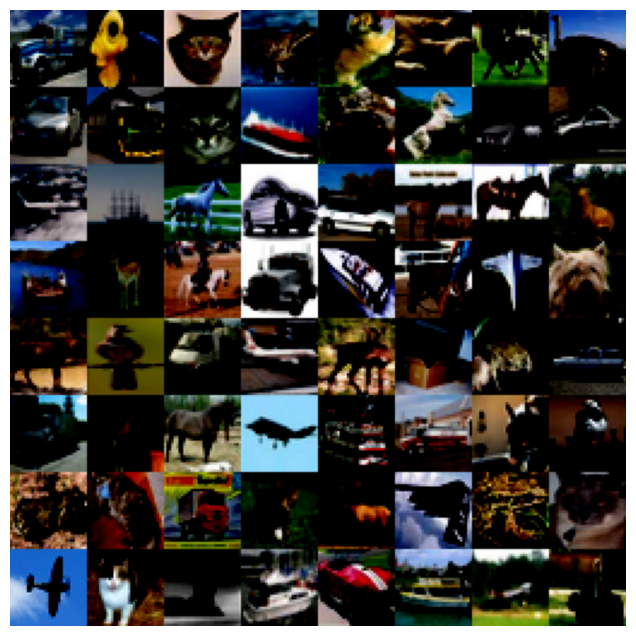

In [32]:
objects, _ = next(iter(trainloader))

grid = torchvision.utils.make_grid(objects, nrow=8, padding=0, scale_each=True)

fig = plt.figure(figsize=(8,8))
plt.imshow(grid.cpu().permute(1,2,0))
plt.axis('off')
plt.show()

In [33]:
image = objects[0].unsqueeze(0)
print(image.shape)
image = image.to(torch.device('cpu'))  #[1, 3, 32, 32] [batch_size, channels, height, width]
print(image.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [34]:
patch_object = PatchEmbedding(32, 4, 128)
patch_embedding = patch_object(image)
print(patch_embedding.shape)

torch.Size([1, 65, 128])
